# Every DeNero "Announcements" at the Same Time

4 years ago, I made a funny video https://www.facebook.com/robert.quitt/videos/1119741718095154 and https://youtu.be/RD62HmxsZ70. It was made with 17 clips of DeNero from the Fall 2016 offering of CS61A. The video was made manually with Adobe Premiere. I had a dream of one day doing a version with all the lecture videos, but I never got around to it.

Now that we're in a global pandemic, this was a good time to find something to do to kill time. I was recently playing around with ffmpeg to make a collage of videos (Baka Mitai meme) and realized I could use a similar strategy to make this video.

Another reason I took on this project is that I have a habit of prematurely optimizing my code. As Donald Knuth says, "premature optimization is the root of all evil". Using this notebook was a good exercise in first hacking together code that worked, then later optimizing it as necessary. The code you see below is the result of iteratively improving the algorithms, and hard-coding some things. I went down a few dead ends (for finding the timestamp, using the subtitles file, or using signal correlation or fft), and that's ok.

The high-level overview of what I did is:

1. Download all the videos (download)
2. For each video, find the timestamp of the "announcements", pad the beginning with silence, and crop the facecam to 96x54 (crop_and_pad)
3. Combine all the videos together into one (combine)

I wasn't planning on publishing the code, but I figured that at least some people would be interested in it. If you have any questions about how it works, feel free to drop an issue or contact me.

Consider this a parting gift to the UC Berkeley EE/CS community that has been a great source of joy and learning for the past 4 years. Thank you.

--Robert Quitt  
UC Berkeley Class of 2020  
8/10/2020

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import numpy as np
print(cv2.__version__)
import subprocess
import pydub
import pydub.playback
import pydub.silence
import os
from vosk import Model, KaldiRecognizer, SetLogLevel

4.3.0


In [69]:
videos = []
with open("video1.txt") as f:
    for line in f:
        code, title = line.strip().split(" ", 1)
        videos.append((code, title))

In [3]:
len(videos)

351

In [3]:
!py -m youtube_dl --rm-cache-dir

Removing cache dir C:\Users\Robert/.cache\youtube-dl ..


# Download

In [4]:
def download(code, title):
    filename = video_filename(code, title)
    if not os.path.isfile(filename):
        print("Downloading", code, title)
        url = subprocess.run(f'py -m youtube_dl --prefer-ffmpeg -f 22 -g -- "{code}"', stdout=subprocess.PIPE).stdout.decode("utf-8").strip()
        command = f'ffmpeg -i "{url}" -t 00:02:30.00 -c copy "{filename}"'
        ret = subprocess.run(command)
        if ret.returncode != 0:
            print("Download failed", code, title)
            return
    else:
        print("File already exists", code, title)
        return None

In [105]:
for v in videos[311:312]:
    download(*v)

In [57]:
def format_timestamp(timestamp):
    return f"{timestamp//1000}.{timestamp % 1000}"
def video_filename(code, title):
    return f"videos/{title}-{code}.mp4"
def cropped_filename(code, title):
    return f"c/{title}-{code}.mp4"
def subtitles(code, title):
    return f"subtitles/{title}-{code}.en.vtt"

# Crop Facecam

In [8]:
def get_crop(code, title, timestamp: int):
    ts = format_timestamp(timestamp)
    video_name = video_filename(code, title)
    frame_name_0 = f"temp_screenshots/{title}-{code}-0.jpg"
    frame_name = f"temp_screenshots/{title}-{code}-{timestamp}.jpg"
    ret = subprocess.run(
        f'ffmpeg -ss {ts} -i "{video_name}" -y -vframes 1 "{frame_name}"'
    )
    assert ret.returncode == 0
    ret = subprocess.run(
        f'ffmpeg -ss 0 -i "{video_name}" -y -vframes 1 "{frame_name_0}"'
    )
    assert ret.returncode == 0
    
    frame = cv2.cvtColor(cv2.imread(frame_name), cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    blacks = cv2.inRange(gray, 0, 5) 
    mask = cv2.dilate(blacks, np.ones((3,3),np.uint8), iterations=1)    
    gray[mask>0] = 255
    
    
    frame_0 = cv2.imread(frame_name_0)
    gray_0 = cv2.cvtColor(frame_0, cv2.COLOR_RGB2GRAY)
    blacks_0 = cv2.inRange(gray_0, 0, 5)
    mask_0 = cv2.dilate(blacks_0, np.ones((3,3),np.uint8), iterations=1)
    gray_0[mask_0>0] = 255
    
#     plt.imshow(gray, cmap="gray")
#     plt.show()
    thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,401,2)
    contours, _ = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    thresh_0 = cv2.adaptiveThreshold(gray_0,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,401,2)
    contours_0, _ = cv2.findContours(thresh_0,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE) 

    cv2.drawContours(frame,contours,-1,(0, 0, 255),3)
    cv2.drawContours(frame,contours_0,-1,(0, 128, 128),2)

#     plt.imshow(thresh)
#     plt.show()
    def loss(c):
        x, y, w, h = cv2.boundingRect(c)
        return ((w * h) - (214 * 120)) ** 2 + ((w/h - 16/9) * 400) ** 2
    big = sorted(contours + contours_0, key=loss)[:1]

    cv2.drawContours(frame,big,-1,(0, 0, 255),3)
    for c in big:
        x, y, w, h = cv2.boundingRect(c)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 4)
    plt.imshow(frame)
    plt.show()
    return x, y, w, h

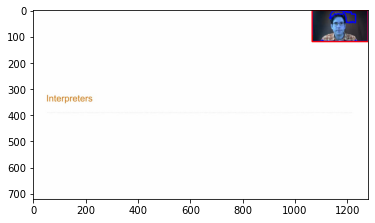

1066 0 214 120


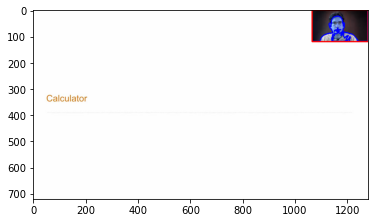

1066 0 214 120


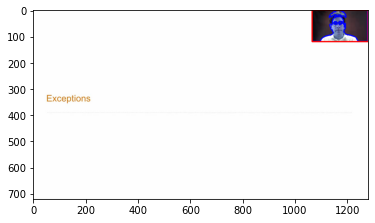

1066 0 214 120


In [7]:
# code, title = videos[2]
for code, title in videos[48:51]:
    if os.path.isfile(video_filename(code, title)):
        x, y, w, h = get_crop(code, title, 0)
        print(x, y, w, h)
        

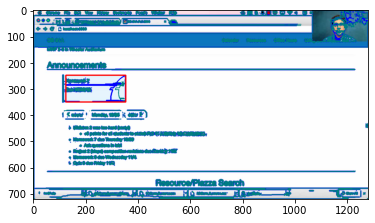

(125, 248, 229, 102)

In [10]:
get_crop(*videos[250], 0)

In [8]:
def identify_manual(chunks):
    for i, chunk in enumerate(chunks):
        loop = True
        while loop:
            pydub.playback.play(chunk)
            c = input("y/n/r/q? ")
            if c == "y":
                return i
            elif c == "n":
                loop = False
                continue
            elif c == "r":
                continue

# Find Timestamp

In [34]:
def find_timestamp(code, title, debug=False):
    i = 0
    wf = pydub.AudioSegment.from_file(video_filename(code, title), "mp4")
    mono = wf.channels == 1
    if not mono:
        c = wf.split_to_mono()
        wf = c[0].overlay(c[1])
    if wf.frame_width != 2:
        print(wf.frame_width)
    assert wf.frame_width == 2
    assert wf.channels == 1
    model = Model("model")
    samples = wf.get_array_of_samples()
    rec = KaldiRecognizer(model, wf.frame_rate)
    words = []
    while 1:
        data = bytes(samples[4000*i:4000*(i+1)])
        if len(data) == 0:
            break
        if rec.AcceptWaveform(data):
            res = eval(rec.Result())
            for word in res["result"]:
                words.append(word)
                if word["word"] in ("announcements", "announcement", "announce"):
                    return word
        i+=1
    # handle 6KVMBt_ZOkk 61A Fall 2018 Lecture 26 Video 1
    # handle Tu3PjH9CIys 61A Fall 2013 Lecture 31 Video 1
    # handle FigFtisptsM 61A Fall 2016 Lecture 27 Video 1
    # 22V_NuOZi88 61A Fall 2015 Lecture 30 Video 1
    for i in range(len(words)-1):
        word = words[i+1]
        word_prev = words[i]
        if ((word_prev["word"] == "and" and word["word"] == "owns") 
        or (word_prev["word"]=="it's" and word["word"]=="months")
        or (word_prev["word"]=="as" and word["word"]=="homework")
        or (word_prev["word"]=="and" and word["word"]=="i")
        or (word_prev["word"]=="and" and word["word"]=="and")):
            return word_prev
    if debug:
        return words
    return None

In [40]:
find_timestamp('I8BlpSQAer8', '61A Fall 2014 Lecture 30 Video 1', debug=True)

[{'conf': 0.610522, 'end': 0.75, 'start': 0.36, 'word': 'six'},
 {'conf': 0.610522, 'end': 0.895285, 'start': 0.75, 'word': 'to'},
 {'conf': 1.0, 'end': 1.11, 'start': 0.895285, 'word': 'one'},
 {'conf': 1.0, 'end': 1.32, 'start': 1.11, 'word': 'a'},
 {'conf': 1.0, 'end': 1.71, 'start': 1.32, 'word': 'lecture'},
 {'conf': 1.0, 'end': 1.95, 'start': 1.71, 'word': 'number'},
 {'conf': 1.0, 'end': 2.52, 'start': 1.95, 'word': 'thirty'},
 {'conf': 0.940792, 'end': 4.05, 'start': 3.6, 'word': "sprint's"},
 {'conf': 0.959168, 'end': 5.55, 'start': 5.04, 'word': 'or'},
 {'conf': 0.998582, 'end': 6.06, 'start': 5.61, 'word': 'eight'},
 {'conf': 1.0, 'end': 6.51, 'start': 6.3, 'word': 'is'},
 {'conf': 0.999999, 'end': 6.75, 'start': 6.51, 'word': 'due'},
 {'conf': 1.0, 'end': 6.93, 'start': 6.75, 'word': 'on'},
 {'conf': 1.0, 'end': 7.56, 'start': 6.93, 'word': 'wednesday'},
 {'conf': 1.0, 'end': 9.57, 'start': 8.94, 'word': 'project'},
 {'conf': 1.0, 'end': 10.26, 'start': 9.57, 'word': 'for'}

In [175]:
def crop_and_pad(code, title):
    video_name = video_filename(code, title)
    outfile = cropped_filename(code, title)
    if not os.path.isfile(video_name):
        print("No download found for", code, title)
        return
    if os.path.isfile(outfile):
        print("Skipping", code, title)
        return
    else:
        print("Finding timestamp for", code, title)
    word = find_timestamp(code, title)
    if not word:
        print("NO ANNOUNCEMENTS FOUND FOR", code, title)
        return
    timestamp = int(word["start"] * 1000)
    print("Timestamp", timestamp)
    x, y, w, h = get_crop(code, title, timestamp)
    print(x, y, w, h)
    padding = 10000 - timestamp
    if padding < 0:
        padding = 0
        seek = timestamp - 10000
    else:
        seek = 0
    seektime = format_timestamp(seek)
    assert padding >= 0
    ts = format_timestamp(timestamp)
    pad = format_timestamp(padding)
    filter_complex = ";".join([
        f"[1:v]crop={w}:{h}:{x}:{y},scale=96:54,setsar=1[vid]",
        f"[1:a]adelay={padding}|{padding}[a]",
        "[0:v][vid]concat=n=2:v=1:a=0[v]",
    ])
    nsamples = int(44100 * padding / 1000)
    command = f'ffmpeg -y \
    -f lavfi -i "color=color=black,scale=96:54,setsar=1,trim=end={pad}" \
    -ss "{seektime}" -i "{video_name}" \
    -filter_complex "{filter_complex}" \
    -t 20 -map "[v]" -map "[a]" "{outfile}"'
    process = subprocess.run(command)
    assert process.returncode == 0

In [39]:
[v for v in videos if v[0] == "I8BlpSQAer8"]

[('I8BlpSQAer8', '61A Fall 2014 Lecture 30 Video 1')]

In [96]:
videos[-32]

('Tu3PjH9CIys', '61A Fall 2013 Lecture 31 Video 1')

In [63]:
def crop_and_pad(code, title):
    video_name = video_filename(code, title)
    outfile = cropped_filename(code, title)
    if not os.path.isfile(video_name):
        print("No download found for", code, title)
        return
    if os.path.isfile(outfile):
#         print("Skipping", code, title)
        return
    else:
        print("Finding timestamp for", code, title)
    if code in manual_timestamps:
        print("Using manual timestamp")
        timestamp = int(manual_timestamps[code] * 1000)
    else:
        word = find_timestamp(code, title)
        if not word:
            print("NO ANNOUNCEMENTS FOUND FOR", code, title)
            return
        timestamp = int(word["start"] * 1000)
    print("Timestamp", timestamp)
    if code == "ysvhdD2gaCQ":
        pass
    if code in manual_crops:
        print("Using manual crop")
        x, y, w, h = manual_crops[code]
    else:
        x, y, w, h = get_crop(code, title, timestamp)
    if "Fall 2015" in title and y > 10:
        x, y, w, h = 1066, 0, 214, 120
        print("Applying Fall 2015 overrride!")
    print(x, y, w, h)
    padding = 10000 - timestamp
    if padding < 0:
        padding = 0
        seek = timestamp - 10000
    else:
        seek = 0
    seektime = format_timestamp(seek)
    assert padding >= 0
    ts = format_timestamp(timestamp)
    pad = format_timestamp(padding)
    filter_complex = ";".join([
        f"[1:v]crop={w}:{h}:{x}:{y},scale=96:54,setsar=1[vid]",
        f"[1:a]adelay={padding}|{padding}[a]",
        "[0:v][vid]concat=n=2:v=1:a=0[v]",
    ])
    nsamples = int(44100 * padding / 1000)
    command = f'ffmpeg -y \
    -f lavfi -i "color=color=black,scale=96:54,setsar=1,trim=end={pad}" \
    -ss "{seektime}" -i "{video_name}" \
    -filter_complex "{filter_complex}" \
    -t 20 -map "[v]" -map "[a]" "{outfile}"'
    process = subprocess.run(command)
    assert process.returncode == 0

In [67]:
for code, title in videos[:]:
    if code in confirmed_skips:
        continue
    crop_and_pad(code, title)

In [61]:
confirmed_skips = [
    "0_LryzvBxFw", # Lecture 1, no announcements
    "jX2XIHEZnEA", # Replaces announcements with updates as an april fool's joke
    "pIbldGLvZi8", # Lecture 1, no announcements
    "v5CP0zpYUcw", # Lecture 1, no announcements
    "tdgcO2Lrf0U", # Lecture 1, welcome
    "74zFPB1Iddw", # Lecture 19, no explicit "announcements"
    "RL8l78CO4rQ", # Lecture 1 
    "2ajhv_e_u5Q", # Aggregation 
    "yC4WPw_6ehY", # Linked lists 
    "Q-CewobDFZM", # Objects
    "Rw6VyLPr128", # Lecture 1 
    "OsMI7P1pE98", # Lecture 1 
    "ztcbniTlPo0", # Lecture 1 
]
todo = [
    "22V_NuOZi88", # 
    "QE2JEtt8OlU", #  
    "j0ojOSce4zA", # 
    "I8BlpSQAer8", # TODO 
    "b6RfDZmnU9Q", # 
    "nYMibzT9kFU", #  
]
manual_timestamps = {
    "I8BlpSQAer8": 3.0
} 
manual_crops = {
    "u3WMWdhfx3U": (938, 0, 214, 120),
    "j0ojOSce4zA": (1016, 0, 264, 149),
}

In [24]:
a = pydub.AudioSegment.from_file(video_filename(*videos[13]), "mp4")
a.split_to_mono

<bound method AudioSegment.split_to_mono of <pydub.audio_segment.AudioSegment object at 0x00000209B68F9D60>>

In [29]:
c = a.split_to_mono()
d = c[0].overlay(c[1])

In [55]:
def combine(videos, outfile="default.mp4"):
    ninputs = len(videos)
    nrows = ninputs // 20
    assert nrows >= 1
    assert 20 <= ninputs <= 400
    overlays_old = (
        ["[0:v]pad=1920:1080:0:0[int1]"]
        + [f"[int{i}][{i}:v]overlay={96*(i%20)}:{54*(i//20)}[int{i+1}]" for i in range(1, ninputs)])
    lastrow = ninputs - (nrows * 20)
    overlays = (
        ["".join([f"[{(20*j)+i}:v]" for i in range(20)])+f"hstack=inputs=20[row{j}]" for j in range(nrows)]
        + (["".join([f"[row{j}]" for j in range(nrows)]) + f"vstack=inputs={nrows}[grid]"] if nrows > 1 else [])
        + (["".join([f"[{20*nrows+i}:v]" for i in range(lastrow)]) + f"hstack=inputs={lastrow}[bottom]"] if lastrow else [])
        + [f"[{'grid' if nrows > 1 else 'row0'}]pad=1920:1080:0:0[{'padded' if lastrow else 'final'}]"]
        + ([f"[padded][bottom]overlay=0:{54*nrows}[final]"] if lastrow else [])
    )
    amix = ["".join([f"[{i}:a]" for i in range(ninputs)])+f"amix=inputs={ninputs}[a]"]
    
    inputs = " ".join([f'-i "{cropped_filename(code, title)}"' for code, title in videos])
    filter_complex = ";".join(overlays + amix)
    command = f'ffmpeg -y {inputs} -filter_complex "{filter_complex}" -map "[final]" -map "[a]" {outfile}'
    print("Command length", len(command))
    proc = subprocess.run(command)
    assert proc.returncode == 0

In [65]:
use = [v for v in videos if os.path.isfile(cropped_filename(*v))]
use.reverse()

In [66]:
combine(use, "test9.mp4")

Command length 24236


In [79]:
!ffmpeg -y -i "test9.mp4" -vf "drawtext=text='__author__ = \"Robert Quitt\"':font=consolas:fontcolor=white:fontsize=24:x=0:y=1000" -c:a copy hello.mp4

ffmpeg version N-93001-g87c165c237 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 8.2.1 (GCC) 20181201
  configuration: --enable-gpl --enable-version3 --enable-sdl2 --enable-fontconfig --enable-gnutls --enable-iconv --enable-libass --enable-libbluray --enable-libfreetype --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopus --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libtheora --enable-libtwolame --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libzimg --enable-lzma --enable-zlib --enable-gmp --enable-libvidstab --enable-libvorbis --enable-libvo-amrwbenc --enable-libmysofa --enable-libspeex --enable-libxvid --enable-libaom --enable-libmfx --enable-amf --enable-ffnvcodec --enable-cuvid --enable-d3d11va --enable-nvenc --enable-nvdec --enable-dxva2 --enable-avisynth --enable-libopenmpt
  libavutil      56. 26.100 / 56. 26.100
  libavc

# Keyword Spotting

In [39]:
def get_audio(code, title):
    return pydub.AudioSegment.from_file(video_filename(code, title))
def plot_audio(audio):
    time = np.arange(0, audio.duration_seconds, 1/audio.frame_rate)
    samples = audio.get_array_of_samples()
    plt.plot(time, samples, linewidth=0.1, alpha=0.7, color='#ff7f00')

In [36]:
a = get_audio(*videos[14])

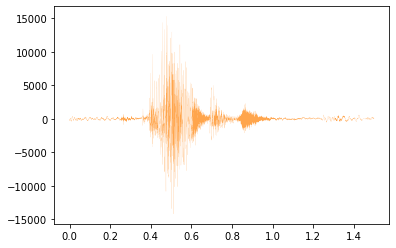

In [40]:
plot_audio(a[3000:4500])

In [65]:
import scipy.fft
import scipy.signal

In [74]:
plt.line(np.abs(fft1))

AttributeError: module 'matplotlib.pyplot' has no attribute 'line'

In [79]:
N = len(xt)

In [130]:
y = np.array(a[:].get_array_of_samples())
x_signal = np.array(a[3000:4500].get_array_of_samples())
x = np.zeros(y.shape)
x[:x_signal.shape[0]] = x_signal
out = scipy.signal.correlate(x, y, mode="full")

In [117]:
np.array(y).shape

(1323000,)

In [83]:
xt = scipy.fft.rfft(x)

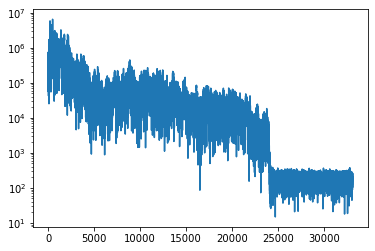

In [88]:
plt.semilogy(np.abs(xt), "-")

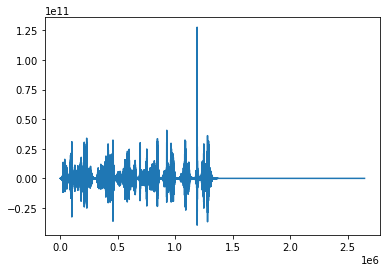

In [131]:
plt.plot(out)

In [136]:
argmax = np.argmax(out)

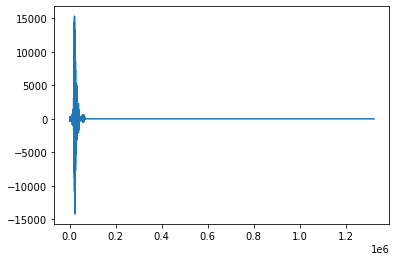

In [128]:
plt.plot(x)

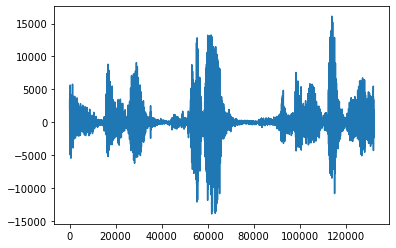

In [139]:
plt.plot(y[argmax:])

In [147]:
wf = pydub.AudioSegment.from_file(video_filename(*videos[0]), "mp4")

In [160]:
#!/usr/bin/env python3

from vosk import Model, KaldiRecognizer, SetLogLevel
import sys
import os
import wave



model = Model("model")
rec = KaldiRecognizer(model, wf.frame_rate)
i = 0
while 1:
    data = bytes(wf[1000*i:1000*(i+1)].get_array_of_samples())
    if len(data) == 0:
        break
    if rec.AcceptWaveform(data):
        res = eval(rec.Result())
        for word in res["result"]:
            if word["word"] == "announcements":
                print(word)
        print(res["text"])
    else:
        res = eval(rec.PartialResult())
    i+=1
final_res = eval(rec.FinalResult())
print(final_res["text"])

{'conf': 1.0, 'end': 5.01, 'start': 4.17, 'word': 'announcements'}
sixty one a lecture number thirty eight announcements this isn't the last lecture in see a sixty win a for the semester
this one is optional of course but it's one of my favorite topics so i do recommend watching the lecture videos and after you watch that see a sixty one a will be concluded so thanks very much for following it all the way through to the end
one of my favorite parts about teaching this


In [161]:
from typing import Dict

In [168]:
find_timestamp(*videos[1])

{'conf': 1.0, 'end': 4.05, 'start': 3.33, 'word': 'announcements'}

In [155]:
print(eval(rec.Result()))

{'result': [{'conf': 1.0, 'end': 27.9, 'start': 27.75, 'word': 'one'}, {'conf': 1.0, 'end': 27.99, 'start': 27.9, 'word': 'of'}, {'conf': 1.0, 'end': 28.11, 'start': 27.99, 'word': 'my'}, {'conf': 1.0, 'end': 28.53, 'start': 28.11, 'word': 'favorite'}, {'conf': 1.0, 'end': 28.98, 'start': 28.56, 'word': 'parts'}, {'conf': 1.0, 'end': 29.31, 'start': 28.98, 'word': 'about'}, {'conf': 1.0, 'end': 29.67, 'start': 29.31, 'word': 'teaching'}, {'conf': 1.0, 'end': 29.88, 'start': 29.67, 'word': 'this'}], 'text': 'one of my favorite parts about teaching this'}


In [52]:
max(sig)

15328

In [131]:
a[3000:4500]